In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
import warnings
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')
from lightgbm import LGBMClassifier

### 1. Cleaning and processing the data

In [2]:
#reading the file
import pandas as pd
df = pd.read_excel('data_hep.xlsx')
print('Dimensions of the dfset are: ',df.shape) 
print(df.columns) #column names
print(df.head(n=5)) #to check that it has been read properly

Dimensions of the dfset are:  (70606, 61)
Index(['Unnamed: 0', 'R2', 'thrustBm', 'thrustOm', 'cosTBTO', 'cosTBz',
       'KSFWVariables__boet__bc', 'KSFWVariables__bomm2__bc',
       'CleoConeCS__bo1__bc', 'CleoConeCS__bo2__bc', 'CleoConeCS__bo3__bc',
       'CleoConeCS__bo4__bc', 'CleoConeCS__bo5__bc', 'CleoConeCS__bo6__bc',
       'CleoConeCS__bo7__bc', 'CleoConeCS__bo8__bc', 'CleoConeCS__bo9__bc',
       'CleoConeCS__bo1__cmROE__bc', 'CleoConeCS__bo2__cmROE__bc',
       'CleoConeCS__bo3__cmROE__bc', 'CleoConeCS__bo4__cmROE__bc',
       'CleoConeCS__bo5__cmROE__bc', 'CleoConeCS__bo6__cmROE__bc',
       'CleoConeCS__bo7__cmROE__bc', 'CleoConeCS__bo8__cmROE__bc',
       'CleoConeCS__bo9__cmROE__bc', 'KSFWVariables__bohso00__bc',
       'KSFWVariables__bohso02__bc', 'KSFWVariables__bohso04__bc',
       'KSFWVariables__bohso10__bc', 'KSFWVariables__bohso12__bc',
       'KSFWVariables__bohso14__bc', 'KSFWVariables__bohso20__bc',
       'KSFWVariables__bohso22__bc', 'KSFWVariables__bohso24

In [3]:
#counts of each event type
print(df['type'].value_counts()) 

type
1    35303
2    23333
3     8172
4     1879
5     1457
0      462
Name: count, dtype: int64


In [62]:
#binary classification: event_types: 0,1--> SIGNAL assign value 1 and event_types2,3,4,5--> BACKGROUND assign value 0)
df['binary_type'] = df['type'].apply(lambda x: 1 if x in [0, 1] else 0)
print(df['binary_type'].value_counts())
print(df['binary_type'].value_counts(normalize=True)) #rel freq

binary_type
1    35765
0    34841
Name: count, dtype: int64
binary_type
1    0.506543
0    0.493457
Name: proportion, dtype: float64


In [5]:
#cleaning the data 
drop_col = []  # we don't want to include columns like the first one (unnamed)

for name in df.columns:
    if 'Unnamed' in name or name == '':
        drop_col.append(name)

# features we want to work with; exclude the binary classification/event_type column
X = df.drop(columns=drop_col + ['type', 'binary_type'], errors='ignore')
Y = df['binary_type'] #type column 0/1

print(df.shape)
print(X.shape)
print(drop_col)


(70606, 62)
(70606, 59)
['Unnamed: 0']


In [6]:
#to check if any columns have null values
print(X.isnull().sum())
#no null values present
#if null values present, we could use imputation:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median') #median since it is robust to outliers; mean is v sensitive to outliers
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns) #pd.Dataframe to convert back from numpy array to dataframe
print(X.shape, X_imputed.shape)   

R2                                   0
thrustBm                             0
thrustOm                             0
cosTBTO                              0
cosTBz                               0
KSFWVariables__boet__bc              0
KSFWVariables__bomm2__bc             0
CleoConeCS__bo1__bc                  0
CleoConeCS__bo2__bc                  0
CleoConeCS__bo3__bc                  0
CleoConeCS__bo4__bc                  0
CleoConeCS__bo5__bc                  0
CleoConeCS__bo6__bc                  0
CleoConeCS__bo7__bc                  0
CleoConeCS__bo8__bc                  0
CleoConeCS__bo9__bc                  0
CleoConeCS__bo1__cmROE__bc           0
CleoConeCS__bo2__cmROE__bc           0
CleoConeCS__bo3__cmROE__bc           0
CleoConeCS__bo4__cmROE__bc           0
CleoConeCS__bo5__cmROE__bc           0
CleoConeCS__bo6__cmROE__bc           0
CleoConeCS__bo7__cmROE__bc           0
CleoConeCS__bo8__cmROE__bc           0
CleoConeCS__bo9__cmROE__bc           0
KSFWVariables__bohso00__b

In [ ]:
#columns that dont change/constant; very small variance are no help in event classification since they will be same for both event types
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=1e-5) 
X_vt = pd.DataFrame(vt.fit_transform(X_imputed), columns=X_imputed.columns[vt.get_support()])
print(X_vt.shape)

(70606, 59)


### 2. Training and comparing different models

In [8]:
#splitting the data set into test and train
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y) 
print("Train:", X_train.shape, "Test:", X_test.shape) 

Train: (56484, 59) Test: (14122, 59)


In [63]:
# certain models like SVM (dist based, not tree based(use threshold)) require this scaling/normalization (mean=0, std dev=1)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### a. Logstic Regression Model

In [ ]:
pca_final = PCA(n_components=0.95)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

# training LightGBM on PCA reduced data
lgbm_pca = LGBMClassifier(
    n_estimators=300,
    random_state=42,
    scale_pos_weight=len(Y_train[Y_train==0]) / len(Y_train[Y_train==1])
)
lgbm_pca.fit(X_train_pca, Y_train)
Y_pred_pca = lgbm_pca.predict(X_test_pca)
Y_proba_pca = lgbm_pca.predict_proba(X_test_pca)[:, 1]

#metrics
acc_pca = accuracy_score(Y_test, Y_pred_pca)
auc_pca = roc_auc_score(Y_test, Y_proba_pca)
cm_pca = confusion_matrix(Y_test, Y_pred_pca)
cr_pca = classification_report(Y_test, Y_pred_pca, digits=4)

print("=== LightGBM (PCA-Reduced Data) ===")
print(f"Accuracy: {acc_pca:.4f}")
print(f"ROC AUC: {auc_pca:.4f}")
print("Confusion Matrix:\n", cm_pca)
print("Classification Report:\n", cr_pca)


[LightGBM] [Info] Number of positive: 28612, number of negative: 27872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 56484, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506551 -> initscore=0.026204
[LightGBM] [Info] Start training from score 0.026204
=== LightGBM (PCA-Reduced Data) ===
Accuracy: 0.8427
ROC AUC: 0.9193
Confusion Matrix:
 [[5774 1195]
 [1027 6126]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8490    0.8285    0.8386      6969
           1     0.8368    0.8564    0.8465      7153

    accuracy                         0.8427     14122
   macro avg     0.8429    0.8425    0.8426     14122
weighted avg     0.8428    0.8427

=== Logistic Regression ===
Accuracy: 0.8430
ROC AUC: 0.9178
Confusion Matrix:
 [[5709 1260]
 [ 957 6196]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8564    0.8192    0.8374      6969
           1     0.8310    0.8662    0.8482      7153

    accuracy                         0.8430     14122
   macro avg     0.8437    0.8427    0.8428     14122
weighted avg     0.8436    0.8430    0.8429     14122



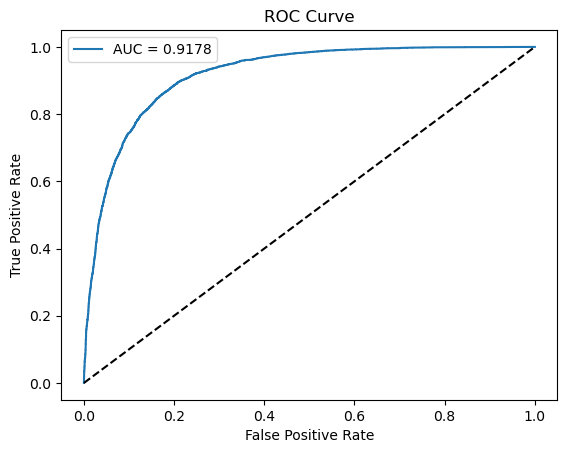

In [ ]:
#initializing model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
#fitting to training data
log_reg.fit(X_train, Y_train) 
#predicting on the test data 
Y_pred = log_reg.predict(X_test) #uses default threshold of 0.5 since data not imbalanced (seen by counts) we can stick w this
Y_proba = log_reg.predict_proba(X_test)[:, 1]  # probabilities for ROC-AUC for those event_type=1

#metrics 
acc = accuracy_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred, digits=4)
auc = roc_auc_score(Y_test, Y_proba)

print("=== Logistic Regression ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

auc = roc_auc_score(Y_test, Y_proba)
fpr, tpr, thresholds = roc_curve(Y_test, Y_proba)

plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line = random guessing AUC 0.5
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



=== Logistic Regression (Scaled Data) ===
Accuracy: 0.8410
ROC AUC: 0.9155
Confusion Matrix:
 [[5705 1264]
 [ 982 6171]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8531    0.8186    0.8355      6969
           1     0.8300    0.8627    0.8460      7153

    accuracy                         0.8410     14122
   macro avg     0.8416    0.8407    0.8408     14122
weighted avg     0.8414    0.8410    0.8409     14122



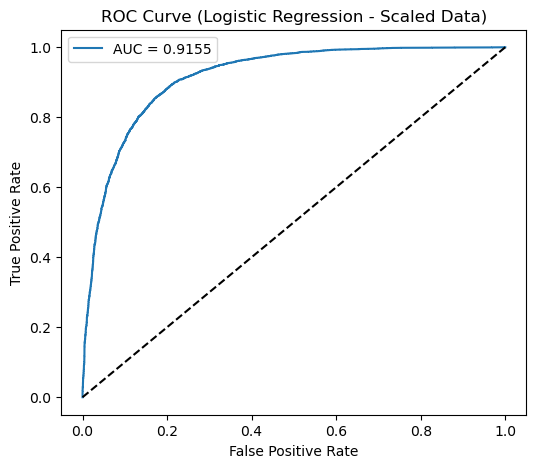

In [11]:
#log_reg with scaled features (just to try out )

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

log_reg.fit(X_train_scaled, Y_train)

Y_pred = log_reg.predict(X_test_scaled)              
Y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]  


acc = accuracy_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred, digits=4)
auc = roc_auc_score(Y_test, Y_proba)

print("=== Logistic Regression (Scaled Data) ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)


fpr, tpr, thresholds = roc_curve(Y_test, Y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression - Scaled Data)')
plt.legend()
plt.show()



#### b. Support Vector Machine

=== Support Vector Machine (SVM) ===
Accuracy: 0.8626
ROC AUC: 0.9349
Confusion Matrix:
 [[5808 1161]
 [ 780 6373]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8816    0.8334    0.8568      6969
           1     0.8459    0.8910    0.8678      7153

    accuracy                         0.8626     14122
   macro avg     0.8638    0.8622    0.8623     14122
weighted avg     0.8635    0.8626    0.8624     14122



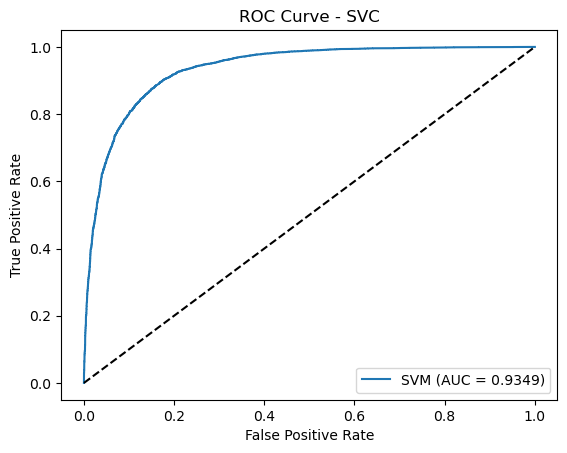

In [ ]:
#SVM
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf',probability=True,class_weight='balanced',random_state=42)   #kernel=rbf non linear hyperplane boundary   

#fitting to scaled training data
svm_model.fit(X_train_scaled, Y_train)
#prediction
Y_pred = svm_model.predict(X_test_scaled)          
Y_proba = svm_model.predict_proba(X_test_scaled)[:, 1] 

#metrics
acc = accuracy_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred, digits=4)
auc = roc_auc_score(Y_test, Y_proba)


print("=== Support Vector Machine (SVM) ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)


fpr, tpr, thresholds = roc_curve(Y_test, Y_proba)
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal = random guessing (AUC = 0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend()
plt.show()

#took a very long time to run


#### c. Random Forest Classifier (decision tree based model)

=== Random Forest ===
Accuracy: 0.8600
ROC AUC: 0.9322
Confusion Matrix:
 [[5847 1122]
 [ 855 6298]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8724    0.8390    0.8554      6969
           1     0.8488    0.8805    0.8643      7153

    accuracy                         0.8600     14122
   macro avg     0.8606    0.8597    0.8599     14122
weighted avg     0.8605    0.8600    0.8599     14122



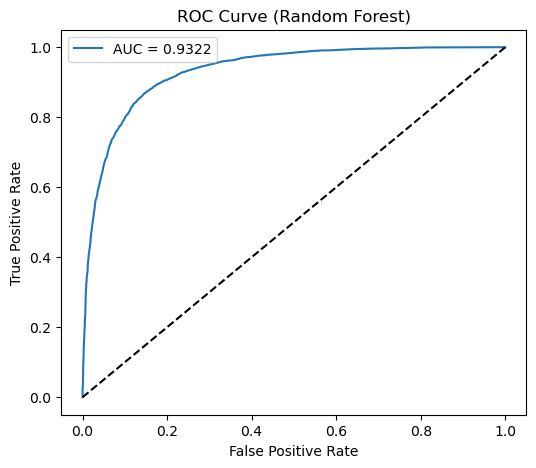

Top 10 important features:
                              Feature  Importance
0                                 R2    0.149115
2                           thrustOm    0.068260
36         KSFWVariables__bohoo2__bc    0.046715
50  KSFWVariables__bohoo2__cmFS1__bc    0.041215
57                            thrust    0.039219
1                           thrustBm    0.036404
3                            cosTBTO    0.035943
54                      foxWolframR2    0.032904
26        KSFWVariables__bohso02__bc    0.029025
7                CleoConeCS__bo1__bc    0.024701


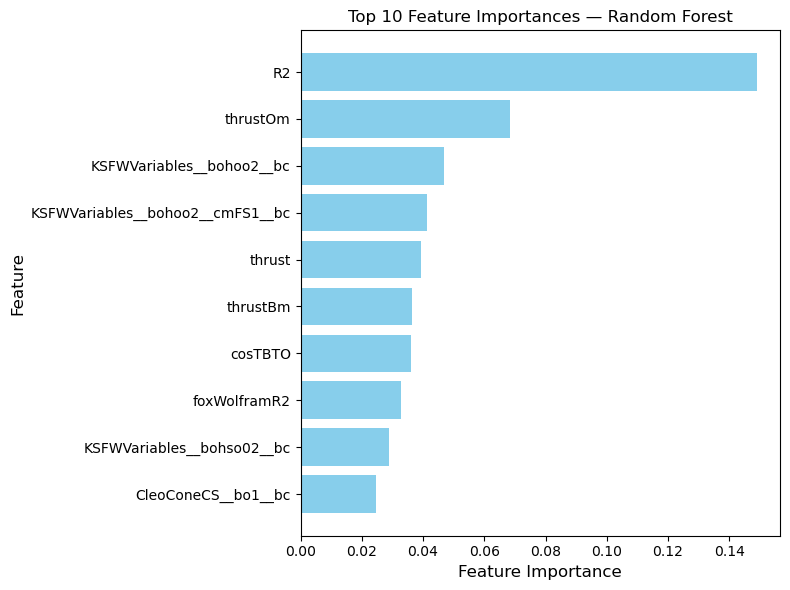

In [15]:
from sklearn.ensemble import RandomForestClassifier

#initializing model
rf = RandomForestClassifier(n_estimators=300,random_state=42,class_weight='balanced')
#fit to training data (raw features, no scaling needed)
rf.fit(X_train, Y_train)
#prediction
Y_pred = rf.predict(X_test)
Y_proba = rf.predict_proba(X_test)[:, 1]  # probability of event type1 

#metrics
acc = accuracy_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred, digits=4)
auc = roc_auc_score(Y_test, Y_proba)

print("=== Random Forest ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

fpr, tpr, thresholds = roc_curve(Y_test, Y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend()
plt.show()

#feature importance (can be used in feature reduction)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 10 important features:\n", feature_importance.head(10))

top_n = 10
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance['Feature'].head(top_n)[::-1],
    feature_importance['Importance'].head(top_n)[::-1],
    color='skyblue',
)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importances — Random Forest')
plt.tight_layout()
plt.show()


#### d. XGBoost - Extreme Gradient Boosting (decision tree based model)
Unlike Random Forest that builds many trees independently (in parallel), XGBoost builds trees sequentially, where each new tree tries to fix the errors (residuals) made by the previous trees.


=== XGBoost ===
Accuracy: 0.8795
ROC AUC: 0.9467
Confusion Matrix:
 [[6035  934]
 [ 768 6385]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8871    0.8660    0.8764      6969
           1     0.8724    0.8926    0.8824      7153

    accuracy                         0.8795     14122
   macro avg     0.8797    0.8793    0.8794     14122
weighted avg     0.8797    0.8795    0.8794     14122



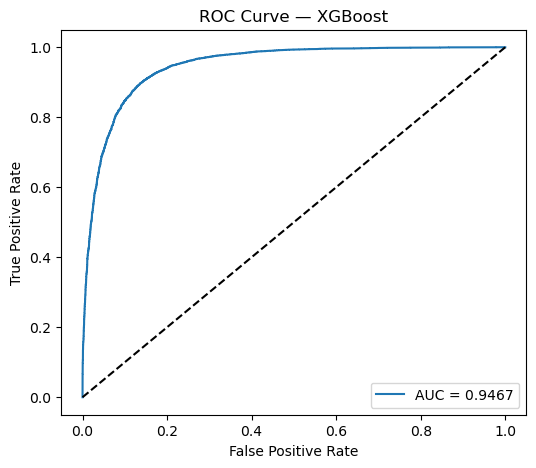

Top 10 important features:
                        Feature  Importance
0                           R2    0.446455
7          CleoConeCS__bo1__bc    0.031988
16  CleoConeCS__bo1__cmROE__bc    0.026503
1                     thrustBm    0.023036
31  KSFWVariables__bohso20__bc    0.020246
34   KSFWVariables__bohoo0__bc    0.017964
6     KSFWVariables__bomm2__bc    0.016884
5      KSFWVariables__boet__bc    0.015454
29  KSFWVariables__bohso12__bc    0.015229
32  KSFWVariables__bohso22__bc    0.014664


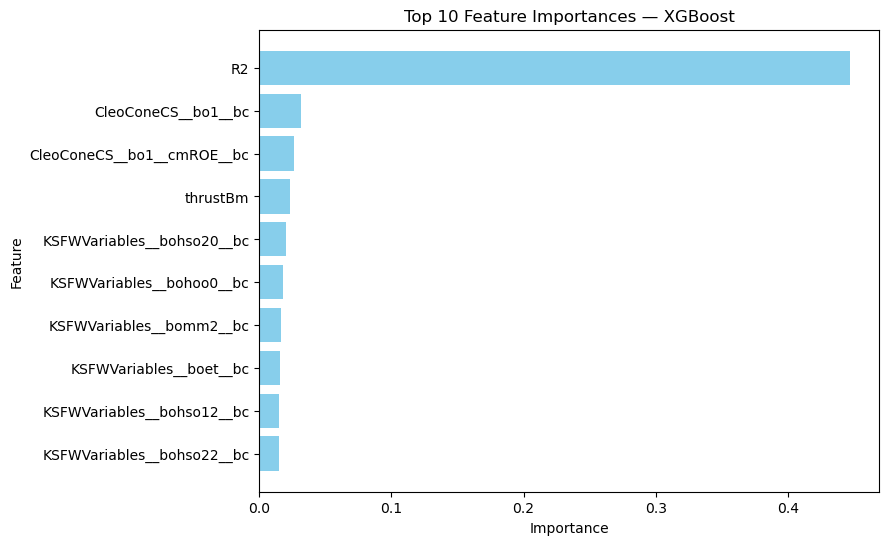

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
#initializing model
xgb = XGBClassifier(n_estimators=300,random_state=42,
scale_pos_weight=len(Y_train[Y_train==0]) / len(Y_train[Y_train==1]), #imporve sensitivity to minority class
    eval_metric='logloss'
)
#fitting to training data
xgb.fit(X_train, Y_train)
#prediction
Y_pred = xgb.predict(X_test)
Y_proba = xgb.predict_proba(X_test)[:, 1]

#metrics
acc = accuracy_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred, digits=4)
auc = roc_auc_score(Y_test, Y_proba)

print("=== XGBoost ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — XGBoost')
plt.legend()
plt.show()

# feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 10 important features:\n", feature_importance.head(10))


plt.figure(figsize=(8,6))
top_n = 10
plt.barh(
    feature_importance['Feature'].head(top_n)[::-1],
    feature_importance['Importance'].head(top_n)[::-1],
    color='skyblue'
)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances — XGBoost')
plt.show()



#### e. LightGBM - Light Gradient Boosting Machine (decision tree based model)
LightGBM grows trees leaf-wise by splitting only the leaf that gives the largest loss reduction/max information gain, unlike XGBoost and Random Forest which grow level-wise, splitting all leaves at the same depth.


[LightGBM] [Info] Number of positive: 28612, number of negative: 27872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 56484, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506551 -> initscore=0.026204
[LightGBM] [Info] Start training from score 0.026204
=== LightGBM ===
Accuracy: 0.8812
ROC AUC: 0.9491
Confusion Matrix:
 [[6019  950]
 [ 727 6426]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8922    0.8637    0.8777      6969
           1     0.8712    0.8984    0.8846      7153

    accuracy                         0.8812     14122
   macro avg     0.8817    0.8810    0.8812     14122
weighted avg     0.8816    0.8812    0.8812     14122



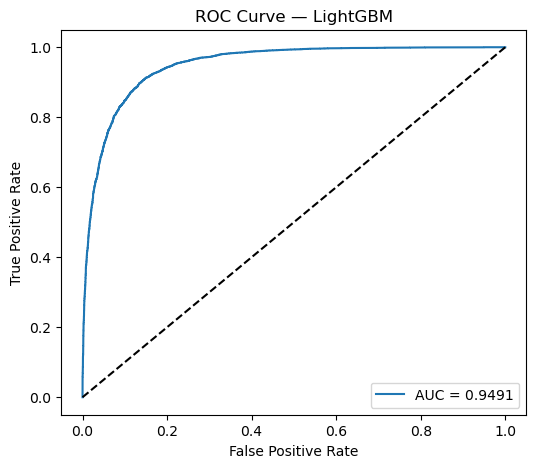

Top 10 important features:
                        Feature  Importance
7          CleoConeCS__bo1__bc    0.061000
1                     thrustBm    0.042778
16  CleoConeCS__bo1__cmROE__bc    0.037778
0                           R2    0.034444
4                       cosTBz    0.033444
8          CleoConeCS__bo2__bc    0.031111
31  KSFWVariables__bohso20__bc    0.030556
5      KSFWVariables__boet__bc    0.027333
34   KSFWVariables__bohoo0__bc    0.026444
29  KSFWVariables__bohso12__bc    0.023333


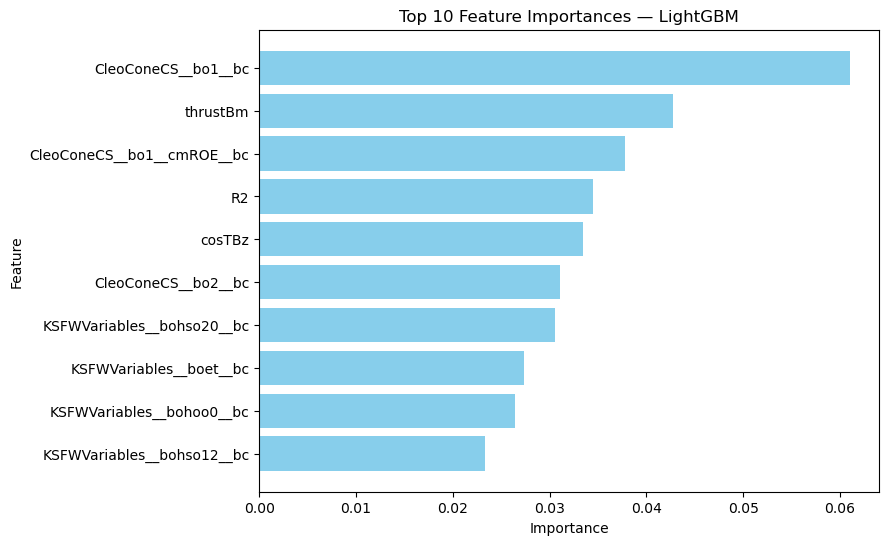

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# initialize the model
lgbm = LGBMClassifier(
    n_estimators=300,
    random_state=42,
    scale_pos_weight=len(Y_train[Y_train==0]) / len(Y_train[Y_train==1]),  # handle class imbalance
)

# fitting the model
lgbm.fit(X_train, Y_train)

# prediction
Y_pred = lgbm.predict(X_test)
Y_proba = lgbm.predict_proba(X_test)[:, 1]

#metrics
acc = accuracy_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred, digits=4)
auc = roc_auc_score(Y_test, Y_proba)

print("=== LightGBM ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — LightGBM')
plt.legend()
plt.show()

# feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importance['Importance'] /= feature_importance['Importance'].sum()

print("Top 10 important features:\n", feature_importance.head(10))


plt.figure(figsize=(8,6))
top_n = 10
plt.barh(
    feature_importance['Feature'].head(top_n)[::-1],
    feature_importance['Importance'].head(top_n)[::-1],
    color='skyblue'
)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances — LightGBM')
plt.show()

Comparison of models on the basis of accuracy and ROC-AUC

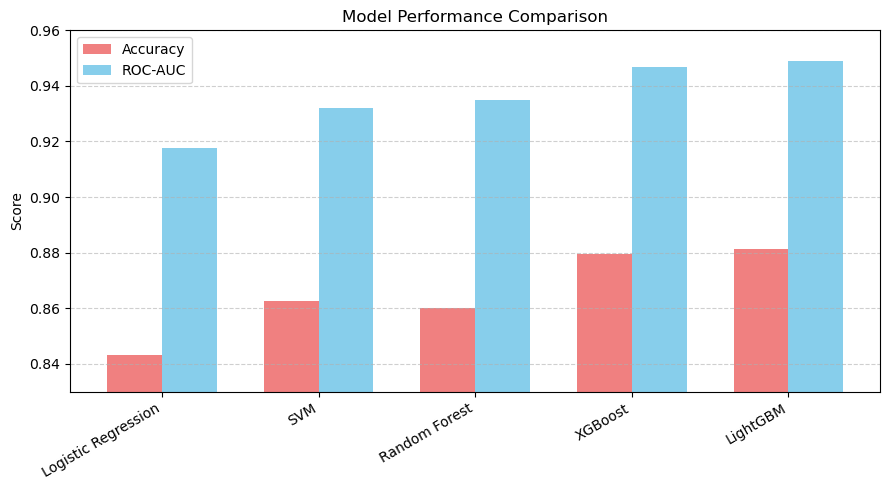

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost', 'LightGBM']
accuracy = [0.8430, 0.8626, 0.8600, 0.8795, 0.8812]
auc = [0.9178, 0.9349, 0.9322, 0.9467, 0.9491]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, accuracy, width, label='Accuracy', color='lightcoral')
plt.bar(x + width/2, auc, width, label='ROC-AUC', color='skyblue')

plt.xticks(x, models, rotation=30, ha='right')
plt.ylabel('Score')
plt.ylim(0.83, 0.96)  #for better resolution of the diff
plt.title('Model Performance Comparison')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### 3. Feature Reduction

Principal Component Analysis (PCA)

Original number of features: 59
Reduced number of features after PCA: 23


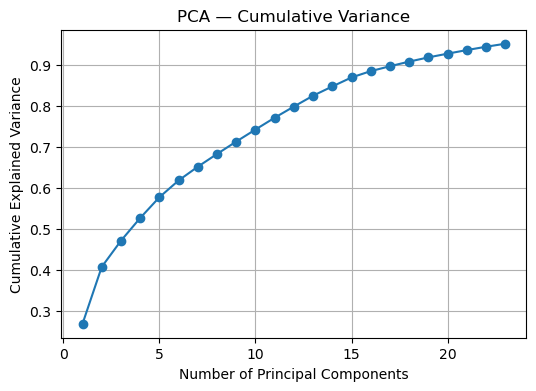

Original number of features: 59
Reduced number of features after PCA: 18


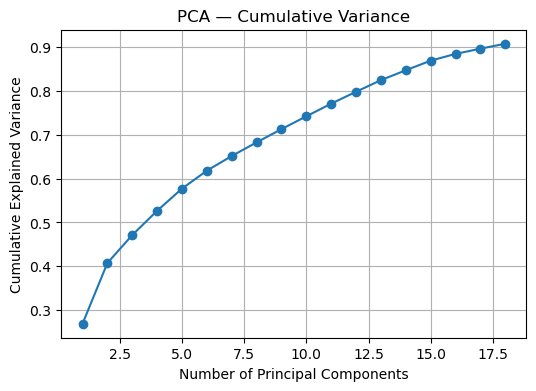

In [ ]:
#PCA so as to retain 95% of the variance
pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

# cumulative variance plot
explained_var = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA — Cumulative Variance')
plt.grid(True)
plt.show()

#PCA so as to retain 90% of the variance
pca = PCA(n_components=0.90)  # automatically choose #components to retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

# cumulative variance plot
explained_var = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA — Cumulative Variance')
plt.grid(True)
plt.show()


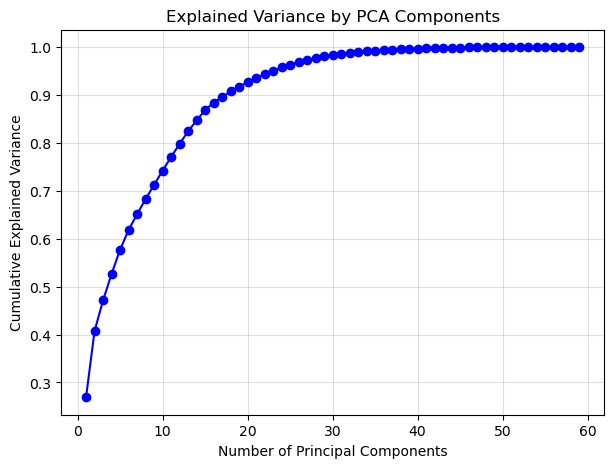

In [ ]:
#cumulative variance plot for all features 
pca = PCA()  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(7,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', color='blue')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(alpha=0.4)
plt.show()



LightGBM model on PCA reduced data

In [44]:
pca_final = PCA(n_components=0.95)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

# training LightGBM on PCA reduced data
lgbm_pca = LGBMClassifier(
    n_estimators=300,
    random_state=42,
    scale_pos_weight=len(Y_train[Y_train==0]) / len(Y_train[Y_train==1])
)
lgbm_pca.fit(X_train_pca, Y_train)
Y_pred_pca = lgbm_pca.predict(X_test_pca)
Y_proba_pca = lgbm_pca.predict_proba(X_test_pca)[:, 1]

#metrics
acc_pca = accuracy_score(Y_test, Y_pred_pca)
auc_pca = roc_auc_score(Y_test, Y_proba_pca)
cm_pca = confusion_matrix(Y_test, Y_pred_pca)
cr_pca = classification_report(Y_test, Y_pred_pca, digits=4)

print("=== LightGBM (PCA-Reduced Data) ===")
print(f"Accuracy: {acc_pca:.4f}")
print(f"ROC AUC: {auc_pca:.4f}")
print("Confusion Matrix:\n", cm_pca)
print("Classification Report:\n", cr_pca)


[LightGBM] [Info] Number of positive: 28612, number of negative: 27872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 56484, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506551 -> initscore=0.026204
[LightGBM] [Info] Start training from score 0.026204
=== LightGBM (PCA-Reduced Data) ===
Accuracy: 0.8427
ROC AUC: 0.9193
Confusion Matrix:
 [[5774 1195]
 [1027 6126]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8490    0.8285    0.8386      6969
           1     0.8368    0.8564    0.8465      7153

    accuracy                         0.8427     14122
   macro avg     0.8429    0.8425    0.8426     14122
weighted avg     0.8428    0.8427

LightGBM model on top10 important features

In [45]:
#feature importances from the trained LightGBM model (before PCA)
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_n = 10 #plotted top 10 above 

top_features = importances['Feature'].head(top_n).tolist()
#reducing data to only top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

#retraining LightGBM on selected features
lgbm_top = LGBMClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)
lgbm_top.fit(X_train_top, Y_train)


Y_pred_top = lgbm_top.predict(X_test_top)
Y_proba_top = lgbm_top.predict_proba(X_test_top)[:, 1]


acc_top = accuracy_score(Y_test, Y_pred_top)
auc_top = roc_auc_score(Y_test, Y_proba_top)

print("=== LightGBM (Top Features Only) ===")
print(f"Accuracy: {acc_top:.4f}")
print(f"ROC AUC: {auc_top:.4f}")
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_top))
print("Classification Report:\n", classification_report(Y_test, Y_pred_top, digits=4))



[LightGBM] [Info] Number of positive: 28612, number of negative: 27872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 56484, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
=== LightGBM (Top Features Only) ===
Accuracy: 0.8706
ROC AUC: 0.9436
Confusion Matrix:
 [[5943 1026]
 [ 802 6351]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8811    0.8528    0.8667      6969
           1     0.8609    0.8879    0.8742      7153

    accuracy                         0.8706     14122
   macro avg     0.8710    0.8703    0.8704     14122
weighted avg     0.8709    0.8

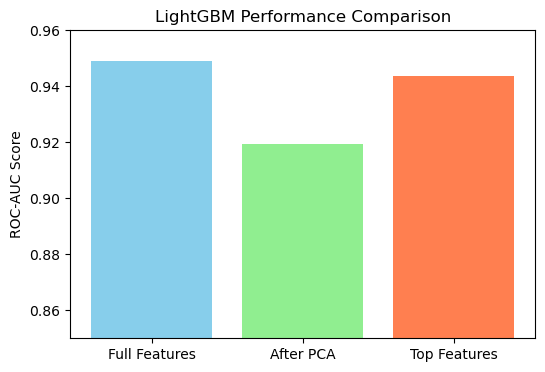

In [51]:
plt.figure(figsize=(6,4))
plt.bar(['Full Features', 'After PCA', 'Top Features'],
        [0.9491, auc_pca, auc_top],
        color=['skyblue', 'lightgreen', 'coral'])
plt.ylabel('ROC-AUC Score')
plt.ylim(0.85, 0.96)
plt.title('LightGBM Performance Comparison')
plt.show()


Comparing time taken to run on the reduced PCA dataset


[LightGBM] [Info] Number of positive: 28612, number of negative: 27872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 56484, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506551 -> initscore=0.026204
[LightGBM] [Info] Start training from score 0.026204
[LightGBM] [Info] Number of positive: 28612, number of negative: 27872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 56484, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506551 -> initscore=0.026204
[LightGBM] [Info] Start training from score 0.026204
       Dataset 

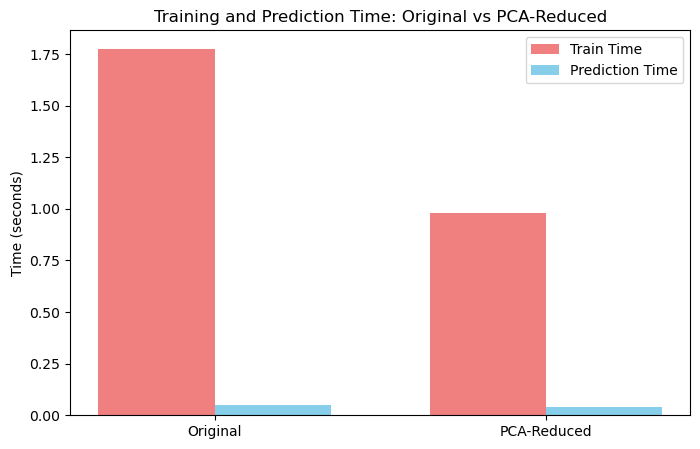

In [ ]:
import time
##Original data
lgbm_orig = LGBMClassifier(
    n_estimators=300,
    random_state=42,
    scale_pos_weight=len(Y_train[Y_train==0]) / len(Y_train[Y_train==1])
)

#training time
start_train = time.time()
lgbm_orig.fit(X_train, Y_train)
end_train = time.time()
train_time_orig = end_train - start_train

#prediction time
start_pred = time.time()
Y_proba_orig = lgbm_orig.predict_proba(X_test)[:,1]
end_pred = time.time()
pred_time_orig = end_pred - start_pred

acc_orig = accuracy_score(Y_test, lgbm_orig.predict(X_test))
auc_orig = roc_auc_score(Y_test, Y_proba_orig)

lgbm_pca = LGBMClassifier(
    n_estimators=300,
    random_state=42,
    scale_pos_weight=len(Y_train[Y_train==0]) / len(Y_train[Y_train==1])
)

##PCA reduced data
#training time
start_train = time.time()
lgbm_pca.fit(X_train_pca, Y_train)
end_train = time.time()
train_time_pca = end_train - start_train

#prediction time
start_pred = time.time()
Y_proba_pca = lgbm_pca.predict_proba(X_test_pca)[:,1]
end_pred = time.time()
pred_time_pca = end_pred - start_pred

acc_pca = accuracy_score(Y_test, lgbm_pca.predict(X_test_pca))
auc_pca = roc_auc_score(Y_test, Y_proba_pca)

results = pd.DataFrame({
    'Dataset': ['Original', 'PCA-Reduced'],
    'Accuracy': [acc_orig, acc_pca],
    'ROC-AUC': [auc_orig, auc_pca],
    'Train Time (s)': [train_time_orig, train_time_pca],
    'Prediction Time (s)': [pred_time_orig, pred_time_pca]
})

print(results)

x = np.arange(len(results))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, results['Train Time (s)'], width, label='Train Time', color='lightcoral')
plt.bar(x + width/2, results['Prediction Time (s)'], width, label='Prediction Time', color='skyblue')
plt.xticks(x, results['Dataset'])
plt.ylabel('Time (seconds)')
plt.title('Training and Prediction Time: Original vs PCA-Reduced')
plt.legend()
plt.show()


Checking for overfitting in LightGBM model

[LightGBM] [Info] Number of positive: 28612, number of negative: 27872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 56484, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506551 -> initscore=0.026204
[LightGBM] [Info] Start training from score 0.026204
=== LightGBM ===
Training Accuracy: 0.9355
Testing Accuracy:  0.8812
Training AUC:      0.9860
Testing AUC:       0.9491
binary_type: Good Generalization (AUC Gap = 0.037)


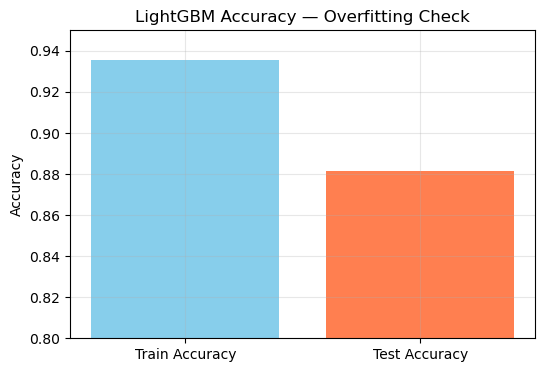

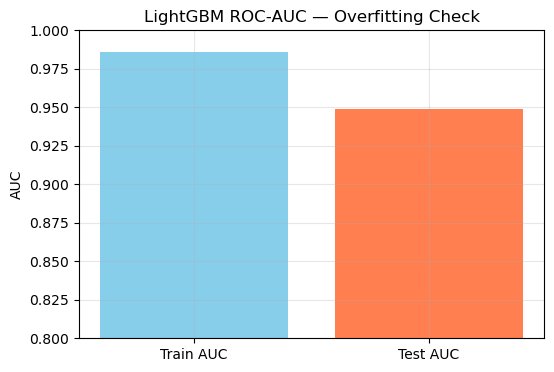

In [ ]:
lgbm = LGBMClassifier(
    n_estimators=300,
    random_state=42,
    scale_pos_weight=len(Y_train[Y_train==0]) / len(Y_train[Y_train==1]),  # handle class imbalance
)

lgbm.fit(X_train, Y_train)

#train vs test data
Y_train_pred = lgbm.predict(X_train)
Y_train_proba = lgbm.predict_proba(X_train)[:, 1]

Y_test_pred = lgbm.predict(X_test)
Y_test_proba = lgbm.predict_proba(X_test)[:, 1]
#metrics
train_acc = accuracy_score(Y_train, Y_train_pred)
test_acc = accuracy_score(Y_test, Y_test_pred)
train_auc = roc_auc_score(Y_train, Y_train_proba)
test_auc = roc_auc_score(Y_test, Y_test_proba)

print("=== LightGBM ===")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Training AUC:      {train_auc:.4f}")
print(f"Testing AUC:       {test_auc:.4f}")

auc_gap = train_auc - test_auc
if auc_gap > 0.05:
    print(f"{name}: Potential Overfitting (AUC Gap = {auc_gap:.3f})")
else:
    print(f"{name}: Good Generalization (AUC Gap = {auc_gap:.3f})")

# graph
plt.figure(figsize=(6,4))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'coral'])
plt.ylim(0.8, 0.95)
plt.title('LightGBM Accuracy — Overfitting Check')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(6,4))
plt.bar(['Train AUC', 'Test AUC'], [train_auc, test_auc], color=['skyblue', 'coral'])
plt.ylim(0.8, 1)
plt.title('LightGBM ROC-AUC — Overfitting Check')
plt.ylabel('AUC')
plt.grid(alpha=0.3)
plt.show()